# Data exploration and descriptive statistics of satellite imagery

This jupyter notebook will parse, collate and analyze satellite imagery files from Maxar (former DigitalGlobe) The parsing of the metadata files (`DeliveryMetadata.xml`) are mainly general and should work for any Maxar product delivery. After parsing of the metadata files into pandas dataframes the code is mainly project specific.

## Imports and setup

In [ ]:
import numpy as np
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import rasterio
from rasterio.plot import reshape_as_image
import geopandas

from modules.metadata_reader import img_metadata_to_dict, add_names_to_metadata_dict, dict_to_df

# Path to location where individual satellite images are located
DATA_PATH = 'data/toulon-laspezia' 
DATA_PATH_IS_RELATIVE = True
DATA_PATH_NPY = 'data/toulon-laspezia-npy' 
DATA_PATH_TILES = 'data/toulon-laspezia-tiles'

# Name of metadata .xml file
METADATA_NAME = 'DeliveryMetadata.xml'

# Names of areas covered by satellite imagery
AREAS = ['La_Spezia', 'Toulon'] # Spelled like the directory names

# Speficy what the xmlns url on top of metadata .xml file is
# (should be second line)
XMLNS = 'http://xsd.digitalglobe.com/xsd/dm'

# pandas options
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
#pd.options.display.max_colwidth = 100

## Metadata parsing from xml to pandas dataframe

Every satellite image delivery from Maxar contains a `DeliveryMetadata.xml` file with important specifications for both the multispectral and panchromatic images. The following functions finds all the `DeliveryMetadata.xml` files contained in all subdirectories of a directory and parses them into the *Pandas DataFrame* format which will be used for further descriptive statistics of the dataset.

In [ ]:
img_metadata_pan, img_metadata_ms = img_metadata_to_dict(METADATA_NAME, 
                                                         DATA_PATH, XMLNS, 
                                                         path_is_relative = DATA_PATH_IS_RELATIVE)

img_metadata_pan = add_names_to_metadata_dict(img_metadata_pan, AREAS)
img_metadata_ms = add_names_to_metadata_dict(img_metadata_ms, AREAS)

img_metadata_pan = dict_to_df(img_metadata_pan)
img_metadata_ms = dict_to_df(img_metadata_ms)

# Checking that string IDs and int IDs are equal in both dataframes (they should)
assert all(img_metadata_ms.index == img_metadata_pan.index)
assert all(img_metadata_ms['int_uid'] == img_metadata_pan['int_uid'])

### Lookup functions for UIDs

In [ ]:
def get_int_uid(string_UIDs):
    return img_metadata_pan.loc[string_UIDs]['int_uid'].tolist()

def get_string_uid(int_UIDs):
    # Could probably be neater
    # Accepts list of ints and single int
    if type(int_UIDs) == int:
        int_UIDs = [int_UIDs]
    l = []
    for int_UID in int_UIDs:
        l.append(img_metadata_pan[img_metadata_pan['int_uid'] == int_UID].index.tolist()[0])
    if len(l) == 1:
        return l[0]
    else:
        return l

## Number of images

In [ ]:
print('Number of panchromatic images:', len(img_metadata_pan))
print('Number of multispectral images:', len(img_metadata_ms), '\n')
if list(img_metadata_pan.index.values) == list(img_metadata_ms.index.values):
    print('Pass: Identical keys. Keys in panchromatic and multispectral dictionaries are identical.')
else: print('Fail: Identical keys. Keys in panchromatic and multispectral dictionaries are not identical.')

Number of panchromatic images: 73
Number of multispectral images: 73 

Pass: Identical keys. Keys in panchromatic and multispectral dictionaries are identical.


## Cleanup and merging of the two dataframes

It is cumbersome to work with two almost identical dataframes so we will merge them and in the process remove quite a number of columns with redundant or irrelevant information.

In [ ]:
def merge_metadata(metadata_df_pan, metadata_df_ms):
    
    # Starting with the panchromatic metadata dataframe
    df = metadata_df_pan.copy(deep = True)
    
    # Dropping the voluminous product columns. 
    # These contain paths and metadata to/of all files, but 90% of the files are not used
    # and it is often a better strategy to look up files by 'glob' or similar functions
    product_columns = df.columns[29:62].to_list()
    #print(product_columns)
    df.drop(columns = product_columns, inplace = True)
    
    # Dropping other columns
    df.drop(columns = 
           ['band0',             # Redundant since it simply states 'Pan' for all rows
            'cloudCover',        # The estimate is of very poor quality
            'imageTypeSize',     # This value looks to be wrong as it is equal for all images
            'imagingTilingType', # Not relevant info
            'isMosaic',          # This seems wrong as no images are mosaics of several images
            'mergingAlgorithm',  # Redundant since there is no band merging going on
            'mergedBand',        # Redundant since there is no band merging going on
            'strip0',            # A lot of duplicate info in this column
            'n_bands',           # Redundant as this is always 1 for Pan
            'n_products',        # Not relevant info
            'n_strips',          # Redundant as this is always 1 as no images are 
            'lineNumber',        # Not relevant info
            'incrementNumber'    # Not relevant info
           ], inplace = True)
    
    # Checking whether earliest and latest are equal. If they are only one of the columns
    # is needed and thus they are merged.
    if df['earliestAcquisitionTime'].equals(df['latestAcquisitionTime']):
        df.drop(columns = 'latestAcquisitionTime', inplace = True)
        df.rename(columns = {'earliestAcquisitionTime': 'acquisitionTime'}, 
                  inplace = True)
    else:
        print('Columns earliestAcquisitionTime and latestAcquisitionTime are not equal. Keeping both.')
    
    # Renaming columns to prepare for merging with the multispectral dataframe.
    df.rename(columns = 
              {'catalogIdentifier': 'pan_catalogIdentifier', 
               'processedProductId': 'pan_processedProductId', 
               'pixelHeight': 'pan_pixelHeight', 
               'pixelWidth': 'pan_pixelWidth', 
               'tif_path' : 'pan_tif_path'}, inplace = True)
    
    # Adding the relevant columns from the multispectral metadata dataframe
    df['ms_catalogIdentifier'] = metadata_df_ms['catalogIdentifier']
    df['ms_processedProductId'] = metadata_df_ms['processedProductId']
    df['ms_pixelHeight'] = metadata_df_ms['pixelHeight']
    df['ms_pixelWidth'] = metadata_df_ms['pixelWidth']
    df['ms_tif_path'] = metadata_df_ms['tif_path']
    df['ms_n_bands'] = metadata_df_ms['n_bands']
    df['ms_band0'] = metadata_df_ms['band0']
    df['ms_band1'] = metadata_df_ms['band1']
    df['ms_band2'] = metadata_df_ms['band2']
    df['ms_band3'] = metadata_df_ms['band3']
    df['ms_band4'] = metadata_df_ms['band4']
    df['ms_band5'] = metadata_df_ms['band5']
    df['ms_band6'] = metadata_df_ms['band6']
    df['ms_band7'] = metadata_df_ms['band7']

    # Reordering the columns for a more intuitive viewing experience
    columns_order = ['int_uid', 
                     'area_name',
                     'sensorVehicle', 
                     'pan_catalogIdentifier', 
                     'ms_catalogIdentifier', 
                     'pan_processedProductId', 
                     'ms_processedProductId',
                     'orderNumber', 
                     'acquisitionTime', 
                     'productionDate', 
                     'updateDate',
                     'bitsPerPixel', 
                     'imageFileFormat', 
                     'pan_pixelHeight', 
                     'pan_pixelWidth', 
                     'ms_pixelHeight', 
                     'ms_pixelWidth', 
                     'isDynamicRangeAdjusted', 
                     'processingLevel', 
                     'resamplingKernel', 
                     'datum', 
                     'mapProjection', 
                     'mapProjectionZone', 
                     'mapProjectionUnit',
                     'offNadirAngle', 
                     'sunAzimuth', 
                     'sunElevation', 
                     'ms_n_bands',
                     'ms_band0', 'ms_band1', 'ms_band2', 'ms_band3', 
                     'ms_band4', 'ms_band5', 'ms_band6', 'ms_band7',
                     'pan_tif_path', 
                     'ms_tif_path'
                    ]
    df = df.reindex(columns = columns_order)
    
    return df

meta = merge_metadata(img_metadata_pan, img_metadata_ms)

# Adding geometry to metadata dataframe

Crawls through the data directory looking for polygon vector files (shapefiles, `.shp`) that define the extent of each image. This geometry data is then used to convert the metadata dataframes to `geopandas.GeoDataFrame` objects, a geospatially enabled extension of `pandas.DataFrame`.

The end result is that we can now do spatial queries directly using the dataframe. This will come in handy later when producing imagery tiles that adhere to the spatial boundaries of the imagery.

In [ ]:
def add_EPSG_to_metadata_df(metadata_df):
    # EPSG is a datum/projection code
    metadata_df['EPSG'] = [32631 if utm_zone == '31' 
                           else 32632 if utm_zone == '32' 
                           else None 
                           for utm_zone in metadata_df['mapProjectionZone']]
    return metadata_df

meta = add_EPSG_to_metadata_df(meta)

In [ ]:
#def get_image_shape(image_UID, pan_or_ms):
#    if pan_or_ms == 'pan':
#        pan_or_ms = 'P2AS'
#    elif pan_or_ms == 'ms':
#        pan_or_ms = 'M2AS'
#    else:
#        print('pan_or_ms must be either "pan" or "ms"')
#
#    epsg = metadata_df.loc[image_UID, 'EPSG']
#    
#    data_path = pathlib.Path(DATA_PATH, image_UID)
#    shp_paths = list(data_path.glob(str('**/*' + pan_or_ms + '*PIXEL_SHAPE.shp')))
#    assert len(shp_paths) == 2
#    for shp_path in shp_paths:
#        shape = geopandas.read_file(shp_path)
#        if shape.crs == 4326: #WGS84 geographic projection
#            return shape.to_crs(epsg = epsg)
        
def metadata_df_to_geodf(metadata_df, pan_or_ms):
    if pan_or_ms == 'pan':
        pan_or_ms = 'P2AS'
    elif pan_or_ms == 'ms':
        pan_or_ms = 'M2AS'
    else:
        print('pan_or_ms must be either "pan" or "ms"')
        
    data_path = pathlib.Path(DATA_PATH)
    shp_paths = list(data_path.glob(str('**/*' + pan_or_ms + '*PIXEL_SHAPE.shp')))
    metadata_df['geometry'] = None
    for shp_path in shp_paths:
        image_UID = shp_path.parts[2]
        epsg = metadata_df.loc[image_UID, 'EPSG']
        shape = geopandas.read_file(shp_path)
        if shape.crs == None: #4326 is WGS84 geographic projection
            continue
        #print(shape['geometry'])
        shape = shape.to_crs(epsg = epsg)
        metadata_df.at[image_UID, 'geometry'] = shape['geometry'][0]
    
    metadata_geodf = geopandas.GeoDataFrame(metadata_df, geometry = 'geometry')
    return metadata_geodf

meta = metadata_df_to_geodf(meta, 'pan')

## Geometry sanity checks

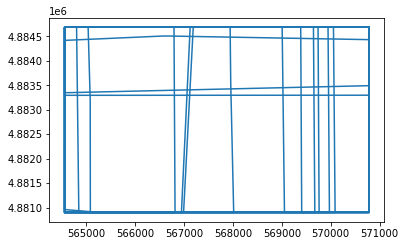

In [ ]:
meta[meta['area_name'] == 'La_Spezia'].boundary.plot()

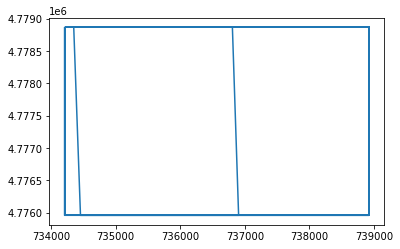

In [ ]:
meta[meta['area_name'] == 'Toulon'].boundary.plot()

## Image areas (m²)

### La Spezia

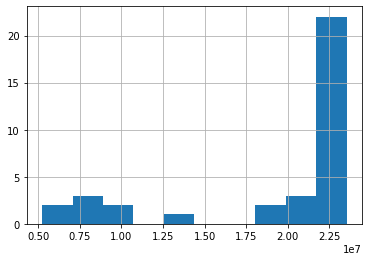

In [ ]:
meta[meta['area_name'] == 'La_Spezia'].area.hist()

In [ ]:
meta[meta['area_name'] == 'La_Spezia'].area.astype('float32').sort_values()

WV02_La_Spezia_2011_05_10_011650587010_0     5229488.0
WV02_La_Spezia_2011_05_02_011650586010_0     6612233.0
GE01_La_Spezia_2012_05_07_011651189010_0     7879835.5
GE01_La_Spezia_2013_07_15_011651183010_0     8500805.0
GE01_La_Spezia_2012_05_16_011651187010_0     8640614.0
GE01_La_Spezia_2013_07_18_011651195010_0     9375969.0
GE01_La_Spezia_2013_07_07_011651184010_0     9574121.0
GE01_La_Spezia_2013_07_23_011651202010_0    12921213.0
WV02_La_Spezia_2019_10_11_011650594010_0    19290832.0
WV02_La_Spezia_2018_05_18_011650597010_0    19642230.0
WV03_La_Spezia_2018_08_06_011650747010_0    20424078.0
WV02_La_Spezia_2018_05_29_011650583010_0    20852588.0
WV03_La_Spezia_2016_01_03_011650743010_0    21568294.0
GE01_La_Spezia_2009_09_25_011651186010_0    22153450.0
WV02_La_Spezia_2013_10_31_011650588010_0    22520150.0
GE01_La_Spezia_2019_01_03_011651196010_0    23487056.0
WV02_La_Spezia_2019_06_03_011650596010_0    23517922.0
GE01_La_Spezia_2012_02_23_011651192010_0    23520230.0
WV02_La_Sp

### Toulon

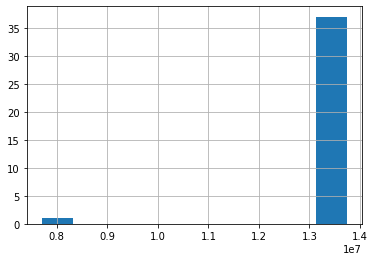

In [ ]:
meta[meta['area_name'] == 'Toulon'].area.hist()

In [ ]:
meta[meta['area_name'] == 'Toulon'].area.astype('float32').sort_values()

GE01_Toulon 2016_03_26_011651193010_0          7711106.5
WV02_Toulon_2016_03_25_011651060010_0         13165338.0
WV02_Toulon_2011_05_04_011651058010_0         13722465.0
GE01_Toulon 2014_10_16_011651185010_0         13722911.0
GE01_Toulon 2010_06_08_011651191010_0         13723262.0
GE01_Toulon 2017_09_05_011651201010_0         13723875.0
WV03_VNIR_Toulon_2016_01_01_011650881010_0    13723995.0
WV02_Toulon_2013_04_07_011651056010_0         13724339.0
GE01_Toulon 2009_03_23_011651190010_0         13724683.0
WV02_Toulon_2016_03_30_011651053010_0         13724940.0
WV02_Toulon_2016_09_28_011651048010_0         13724940.0
WV02_Toulon_2019_09_11_011650876010_0         13724940.0
WV02_Toulon_2019_08_04_011650878010_0         13724940.0
WV02_Toulon_2019_10_16_011650874010_0         13724940.0
WV02_Toulon_2019_12_15_011650875010_0         13724940.0
WV02_Toulon_2019_07_29_011650877010_0         13724940.0
WV02_Toulon_2016_03_22_011651057010_0         13724940.0
WV02_Toulon_2016_03_14_01165106

# Clouds

In [ ]:
CLOUDS_PATH = 'data/toulon-laspezia-clouds'

clouds_laspezia = geopandas.read_file(pathlib.Path(CLOUDS_PATH, 'laspezia-clouds.shp'))
clouds_toulon = geopandas.read_file(pathlib.Path(CLOUDS_PATH, 'toulon-clouds.shp'))

In [ ]:
def add_area_to_metadata_gdf(metadata_gdf):
    metadata_gdf['area_m2'] = metadata_gdf['geometry'].area.astype('float32')
    return metadata_gdf

meta = add_area_to_metadata_gdf(meta)

In [ ]:
def add_clouds_area_to_metadata_gdf(metadata_gdf, clouds_gdf):
    for image_UID in clouds_gdf['image_id'].unique():
        clouds_sum = 0.0
        for polygon in clouds_gdf.loc[clouds_gdf['image_id'] == image_UID, 'geometry']:
            #print(type(polygon.area))
            clouds_sum += polygon.area
        metadata_gdf.at[image_UID, 'clouds_area_m2'] = clouds_sum
        
    metadata_gdf = metadata_gdf.astype({'clouds_area_m2': 'float32'})
    metadata_gdf['clouds_area_m2'].fillna(0.0, inplace = True)
    
    return metadata_gdf

meta = add_clouds_area_to_metadata_gdf(meta, clouds_laspezia)
meta = add_clouds_area_to_metadata_gdf(meta, clouds_toulon)

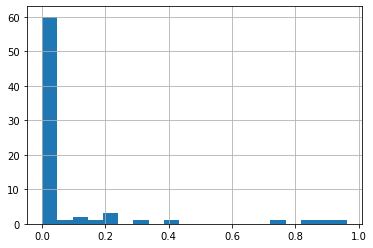

In [ ]:
def add_cloud_ratio_to_metadata_gdf(metadata_gdf):
    metadata_gdf['cloud_ratio'] = metadata_gdf['clouds_area_m2'] / metadata_gdf['area_m2']
    return metadata_gdf

meta = add_cloud_ratio_to_metadata_gdf(meta)

meta['cloud_ratio'].hist(bins = 20)

In [ ]:
#meta['cloud_ratio'].sort_values()

## Area and clouds statistics

In [ ]:
def add_max_image_size_to_metadata_gdf(metadata_gdf):
    for area_name in metadata_gdf['area_name'].unique():
        
        # Find the max area for each location
        max_area_m2 = metadata_gdf.loc[metadata_gdf['area_name'] == area_name, 'area_m2'].max()
        
        # Add this to a column in the gdf
        metadata_gdf.loc[metadata_gdf['area_name'] == area_name, 'area_m2_max'] = max_area_m2
        #['area_m2_max'] = max_area_m2
    
    # Calculate an "area_ratio", a measure of how large an image is compared to the max sized image
    # Low number means that the image is small and only cover a minor part of the area
    metadata_gdf['area_ratio'] = metadata_gdf['area_m2']/metadata_gdf['area_m2_max']

    return metadata_gdf

meta = add_max_image_size_to_metadata_gdf(meta)

In [ ]:
#meta['area_ratio'].sort_values()

In [ ]:
def train_val_test_split(metadata_gdf, 
                         area_ratio_treshold, 
                         cloud_ratio_treshold, 
                         train_val_test_split,
                         seed = 18):
    df = metadata_gdf
    df['train_val_test'] = None
    np.random.seed(seed)
    
    # WV03
    print('Starting with', len(metadata_gdf), 'images')
    print('Assigning all WV03 to training set...')
    # There are not many of these and they are not well distributed between the areas so no effort will
    # be done on evaluating on these images.
    df.loc[df['sensorVehicle'] == 'WV03_VNIR', 'train_val_test'] = 'train'
    print('Number of images left to assign:', 
          len(df[df['train_val_test'].isnull()]))
    
    # Randomly assign GE01 to either val or test sets
    # These will not be used for training, but serve as a measure of how well the model can perform on 
    # a different sensor
    print('Randomly assigning GE01 images to val or test sets')
    for area_name in df['area_name'].unique():
        n = len(df[(df['sensorVehicle'] == 'GE01') & (df['area_name'] == area_name)])
        partition =  ['val'] * int(n/2) + ['test'] * (n - int(n/2))
        np.random.shuffle(partition)
        df.loc[(df['sensorVehicle'] == 'GE01') & (df['area_name'] == area_name), 'train_val_test'] = partition        
    print('Number of images left to assign:', 
          len(df[df['train_val_test'].isnull()]))

    # WV02:
    print('Assigning very cloudy WV02 images to training set')
    # Assign images with cloud ratio higher than threshold to training set
    # In other words: Remove very cloudy images from validation and test set
    df.loc[(df['cloud_ratio'] > cloud_ratio_treshold) & (df['sensorVehicle'] == 'WV02'), 
           'train_val_test'] = 'train'
    print('Number of images left to assign:', 
          len(df[df['train_val_test'].isnull()]))
    
    print('Assigning very small WV02 images to training set')
    # We want to make sure that val and test sets are representative and not dominated by
    # small images that only cover parts of the overall image area
    df.loc[(df['area_ratio'] < area_ratio_treshold) & (df['sensorVehicle'] == 'WV02'), 
           'train_val_test'] = 'train'
    print('Number of images left to assign:', 
          len(df[df['train_val_test'].isnull()]))


    print('Randomly assigning remaining WV02 images to val or test sets')
    for area_name in df['area_name'].unique():
        selection = (df['sensorVehicle'] == 'WV02') & (df['train_val_test'].isnull()) & (df['area_name'] == area_name)
        n = len(df[selection])
        n_val = int(n*train_val_test_split[1])
        n_test = int(n*train_val_test_split[2])
        n_train = n - (n_val + n_test)
        partition =  ['val'] * n_val + ['test'] * n_test + ['train'] * n_train
        np.random.shuffle(partition)
        df.loc[selection, 'train_val_test'] = partition
    print('Number of images left to assign:', 
          len(df[df['train_val_test'].isnull()]))
    print('Finished')
    return df
    
    
meta = train_val_test_split(meta, 
                            area_ratio_treshold = 0.5, 
                            cloud_ratio_treshold = 1, 
                            train_val_test_split = [0.5, 0.25, 0.25],
                            seed = 18)

Starting with 73 images
Assigning all WV03 to training set...
Number of images left to assign: 62
Randomly assigning GE01 images to val or test sets
Number of images left to assign: 42
Assigning very cloudy WV02 images to training set
Number of images left to assign: 42
Assigning very small WV02 images to training set
Number of images left to assign: 40
Randomly assigning remaining WV02 images to val or test sets
Number of images left to assign: 0
Finished


In [ ]:
#meta['train_val_test']

# Distribution of images across the train/val/test partition

## Contingency tables

In [ ]:
pd.crosstab(meta['train_val_test'], meta['area_name'], margins=True)

area_name,La_Spezia,Toulon,All
train_val_test,,,
test,11,10,21
train,14,19,33
val,10,9,19
All,35,38,73


In [ ]:
pd.crosstab(meta['train_val_test'], meta['sensorVehicle'], margins=True)

sensorVehicle,GE01,WV02,WV03_VNIR,All
train_val_test,,,,
test,11,10,0,21
train,0,22,11,33
val,9,10,0,19
All,20,42,11,73


In [ ]:
pd.crosstab(meta['area_name'], meta['sensorVehicle'], margins=True)

sensorVehicle,GE01,WV02,WV03_VNIR,All
area_name,,,,
La_Spezia,11,22,2,35
Toulon,9,20,9,38
All,20,42,11,73


## Histograms

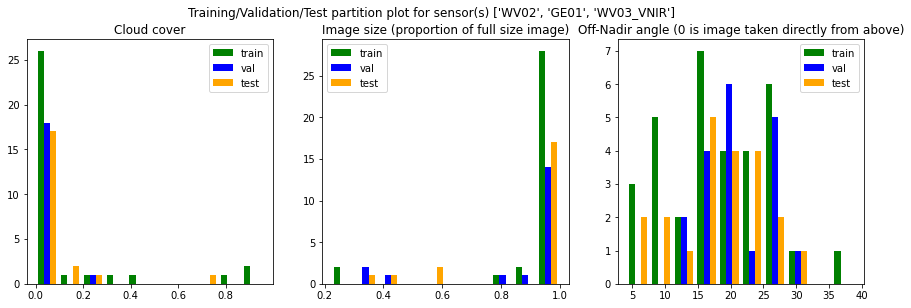

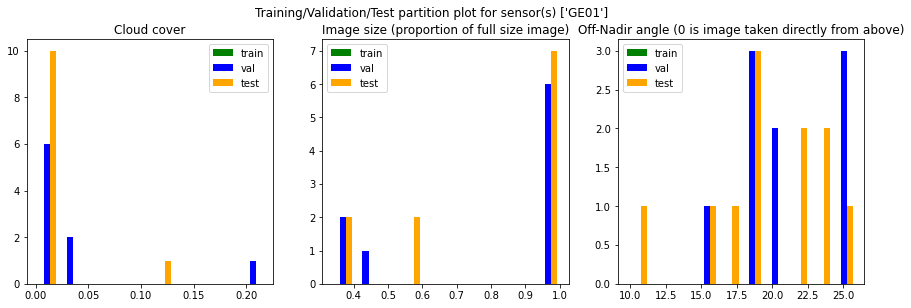

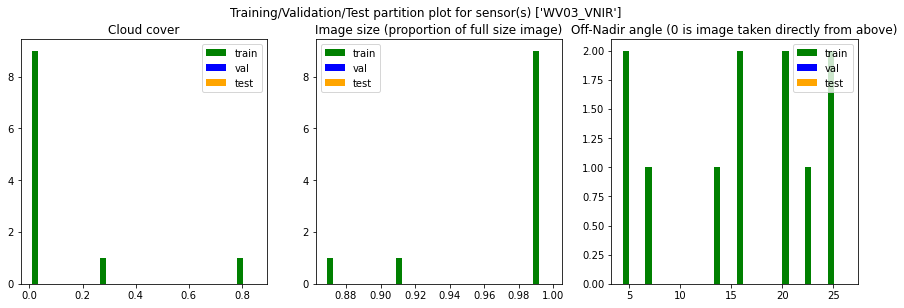

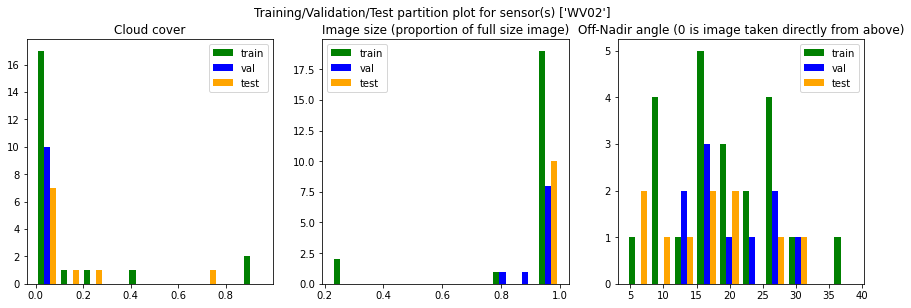

In [ ]:
def hist_by_partition(meta, sensor_filter):
    # Convert string to list if only one sensor_filter is given
    if type(sensor_filter) == str:
        sensor_filter = [sensor_filter]
        
    train_val_test = ['train', 'val', 'test']
    colors = ['green', 'blue', 'orange']
    
    fig, axs = plt.subplots(1, 3, figsize=(15,4.5))
    
    axs[0].hist([meta.loc[(meta['train_val_test'] == x) & (meta['sensorVehicle'].isin(sensor_filter)), 
                             'cloud_ratio'] for x in train_val_test], 
                   color = colors)
    axs[0].set_title('Cloud cover')
    axs[0].legend(train_val_test)
    
    axs[1].hist([meta.loc[(meta['train_val_test'] == x) & (meta['sensorVehicle'].isin(sensor_filter)), 
                             'area_ratio'] for x in train_val_test], 
                    color = colors)
    axs[1].set_title('Image size (proportion of full size image)')
    axs[1].legend(train_val_test)
    
    axs[2].hist([meta.loc[(meta['train_val_test'] == x) & (meta['sensorVehicle'].isin(sensor_filter)), 
                             'offNadirAngle'] for x in train_val_test], 
                    color = colors)
    axs[2].set_title('Off-Nadir angle (0 is image taken directly from above)')
    axs[2].legend(train_val_test)
    
    fig.suptitle(str('Training/Validation/Test partition plot for sensor(s) ' + str(sensor_filter)))

hist_by_partition(meta, sensor_filter = ['WV02', 'GE01', 'WV03_VNIR'])
hist_by_partition(meta, sensor_filter = 'GE01')
hist_by_partition(meta, sensor_filter = 'WV03_VNIR')
hist_by_partition(meta, sensor_filter = 'WV02')